In [1]:
import pandas as pd
import seaborn
import sklearn
import sklearn.ensemble
import sklearn.compose
from sklearn.preprocessing import *
from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_selection import VarianceThreshold
import os

In [2]:
data = pd.read_csv("data/Automobile_data.csv")
display(data)
data[data["normalized-losses"] == "?"]

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.4,23.0,106,4800,26,27,22470


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
5,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.4,8.5,110,5500,19,25,15250
7,1,?,audi,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.4,8.5,110,5500,19,25,18920
9,0,?,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.4,7.0,160,5500,16,22,?
14,1,?,bmw,gas,std,four,sedan,rwd,front,103.5,...,164,mpfi,3.31,3.19,9.0,121,4250,20,25,24565
15,0,?,bmw,gas,std,four,sedan,rwd,front,103.5,...,209,mpfi,3.62,3.39,8.0,182,5400,16,22,30760
16,0,?,bmw,gas,std,two,sedan,rwd,front,103.5,...,209,mpfi,3.62,3.39,8.0,182,5400,16,22,41315
17,0,?,bmw,gas,std,four,sedan,rwd,front,110.0,...,209,mpfi,3.62,3.39,8.0,182,5400,15,20,36880


In [3]:
data_with_none = data.replace('?', None)

def find_meaning(df, grouping, column):
    mean = {}
    for index, row in df.iterrows():
        if row[column] is None:
            continue
        if row[grouping] not in mean:
            mean[row[grouping]] = np.array([])
        mean[row[grouping]] = np.append(mean[row[grouping]], [float(row[column])])
    for group, values in mean.items():
        mean[group] = np.mean(mean[group])
    return mean

mean_symbols = find_meaning(data_with_none, "symboling", "normalized-losses")
mean_curb = find_meaning(data_with_none, "curb-weight", "price")
display(mean_symbols)
display(mean_curb)

{2: 125.6896551724138,
 1: 128.5744680851064,
 0: 113.16666666666667,
 -1: 85.6,
 3: 168.64705882352942,
 -2: 103.0}

{2548: 14997.5,
 2823: 16500.0,
 2337: 10367.5,
 2824: 17450.0,
 2507: 15250.0,
 2844: 17710.0,
 2954: 18920.0,
 3086: 23875.0,
 2395: 16677.5,
 2710: 20970.0,
 2765: 21105.0,
 3055: 24565.0,
 3230: 21600.0,
 3380: 41315.0,
 3505: 36880.0,
 1488: 5151.0,
 1874: 6295.0,
 1909: 6575.0,
 1876: 5974.5,
 2128: 7957.0,
 1967: 6229.0,
 1989: 6997.666666666667,
 2191: 8083.5,
 2535: 8921.0,
 2811: 12964.0,
 1713: 6479.0,
 1819: 6855.0,
 1837: 5399.0,
 1940: 6529.0,
 1956: 7129.0,
 2010: 7295.0,
 2024: 7322.0,
 2236: 7895.0,
 2289: 9095.0,
 2304: 8845.0,
 2372: 10295.0,
 2465: 12945.0,
 2293: 10345.0,
 2734: 11048.0,
 4066: 33900.0,
 3950: 36000.0,
 1890: 5195.0,
 1900: 6095.0,
 1905: 6795.0,
 1945: 6695.0,
 1950: 7395.0,
 2380: 11395.0,
 2385: 10579.5,
 2500: 15645.0,
 2410: 9370.0,
 2443: 10795.0,
 2425: 11245.0,
 2670: 18280.0,
 2700: 18344.0,
 3515: 25552.0,
 3750: 28248.0,
 3495: 28176.0,
 3770: 31600.0,
 3740: 34184.0,
 3685: 35056.0,
 3900: 40960.0,
 3715: 45400.0,
 2910: 16503.0,
 1918:

In [4]:

def replace_with_meaning(row):
    
    if row["normalized-losses"] is None:
        symbol = row["symboling"]
        row["normalized-losses"] = mean_symbols[symbol]
    if row["price"] is None:
        row["price"] = mean_curb[row["curb-weight"]] if row["curb-weight"] in mean_curb else None
    return row

filtered_data = data_with_none.apply(lambda row: replace_with_meaning(row), axis = 1).dropna()
filtered_data

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,168.647059,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,168.647059,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,128.574468,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.4,23.0,106,4800,26,27,22470


In [5]:
changed_data = filtered_data
changed_data['symboling'] = MinMaxScaler().fit_transform(changed_data['symboling'].values.reshape((-1, 1)))
changed_data['make'] = LabelEncoder().fit_transform(changed_data['make'].values)
changed_data['fuel-type'] = LabelEncoder().fit_transform(changed_data['fuel-type'].values)
changed_data['aspiration'] = LabelEncoder().fit_transform(changed_data['aspiration'].values)
changed_data['num-of-doors'] = LabelEncoder().fit_transform(changed_data['num-of-doors'].values)
changed_data['body-style'] = LabelEncoder().fit_transform(changed_data['body-style'].values)
changed_data['drive-wheels'] = LabelEncoder().fit_transform(changed_data['drive-wheels'].values)
changed_data['engine-location'] = LabelEncoder().fit_transform(changed_data['engine-location'].values)
changed_data['engine-type'] = LabelEncoder().fit_transform(changed_data['engine-type'].values)
changed_data['fuel-system'] = LabelEncoder().fit_transform(changed_data['fuel-system'].values)
changed_data['num-of-cylinders'] = LabelEncoder().fit_transform(changed_data['num-of-cylinders'].values)
changed_data['price'] = changed_data['price'].apply(lambda x: float(x))
changed_data['normalized-losses'] = changed_data['normalized-losses'].apply(lambda x: float(x))
display(changed_data)
changed_data["engine-location"].unique()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,1.0,168.647059,0,1,0,1,0,2,0,88.6,...,130,4,3.47,2.68,9.0,111,5000,21,27,13495.0
1,1.0,168.647059,0,1,0,1,0,2,0,88.6,...,130,4,3.47,2.68,9.0,111,5000,21,27,16500.0
2,0.6,128.574468,0,1,0,1,2,2,0,94.5,...,152,4,2.68,3.47,9.0,154,5000,19,26,16500.0
3,0.8,164.000000,1,1,0,0,3,1,0,99.8,...,109,4,3.19,3.4,10.0,102,5500,24,30,13950.0
4,0.8,164.000000,1,1,0,0,3,0,0,99.4,...,136,4,3.19,3.4,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.2,95.000000,20,1,0,0,3,2,0,109.1,...,141,4,3.78,3.15,9.5,114,5400,23,28,16845.0
201,0.2,95.000000,20,1,1,0,3,2,0,109.1,...,141,4,3.78,3.15,8.7,160,5300,19,25,19045.0
202,0.2,95.000000,20,1,0,0,3,2,0,109.1,...,173,4,3.58,2.87,8.8,134,5500,18,23,21485.0
203,0.2,95.000000,20,0,1,0,3,2,0,109.1,...,145,2,3.01,3.4,23.0,106,4800,26,27,22470.0


array([0, 1])

In [6]:
cleaned_auto_data = changed_data[filtered_data.price < filtered_data.price.quantile(0.9)]
cleaned_auto_data

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,1.0,168.647059,0,1,0,1,0,2,0,88.6,...,130,4,3.47,2.68,9.0,111,5000,21,27,13495.0
1,1.0,168.647059,0,1,0,1,0,2,0,88.6,...,130,4,3.47,2.68,9.0,111,5000,21,27,16500.0
2,0.6,128.574468,0,1,0,1,2,2,0,94.5,...,152,4,2.68,3.47,9.0,154,5000,19,26,16500.0
3,0.8,164.000000,1,1,0,0,3,1,0,99.8,...,109,4,3.19,3.4,10.0,102,5500,24,30,13950.0
4,0.8,164.000000,1,1,0,0,3,0,0,99.4,...,136,4,3.19,3.4,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.2,74.000000,20,1,1,0,4,2,0,104.3,...,130,4,3.62,3.15,7.5,162,5100,17,22,18950.0
200,0.2,95.000000,20,1,0,0,3,2,0,109.1,...,141,4,3.78,3.15,9.5,114,5400,23,28,16845.0
201,0.2,95.000000,20,1,1,0,3,2,0,109.1,...,141,4,3.78,3.15,8.7,160,5300,19,25,19045.0
202,0.2,95.000000,20,1,0,0,3,2,0,109.1,...,173,4,3.58,2.87,8.8,134,5500,18,23,21485.0


In [7]:

columns_array = changed_data.columns
selection = VarianceThreshold(threshold=(.8 * (1 - 0.8)))
selected_data = selection.fit_transform(cleaned_auto_data.drop(["price"], axis=1), cleaned_auto_data["price"])
selected_features = selection.get_feature_names_out(columns_array[:len(columns_array) - 1])
selected_data = pd.DataFrame(selected_data, columns=selected_features)
deleted_features = np.array([], dtype=str)
for feature in columns_array[:len(columns_array) - 1]:
    if feature not in selected_features:
        deleted_features = np.append(deleted_features, feature)

display(pd.DataFrame(selected_features))
display(pd.DataFrame(deleted_features))
display(selected_data)

,0
0,normalized-losses
1,make
2,num-of-doors
3,body-style
4,drive-wheels
5,wheel-base
6,length
7,width
8,height
9,curb-weight


,0
0,symboling
1,fuel-type
2,aspiration
3,engine-location
4,num-of-cylinders
5,bore
6,stroke


,normalized-losses,make,num-of-doors,body-style,drive-wheels,wheel-base,length,width,height,curb-weight,engine-type,engine-size,fuel-system,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,168.647059,0,1,0,2,88.6,168.8,64.1,48.8,2548,0,130,4,9.0,111,5000,21,27
1,168.647059,0,1,0,2,88.6,168.8,64.1,48.8,2548,0,130,4,9.0,111,5000,21,27
2,128.574468,0,1,2,2,94.5,171.2,65.5,52.4,2823,4,152,4,9.0,154,5000,19,26
3,164.0,1,0,3,1,99.8,176.6,66.2,54.3,2337,2,109,4,10.0,102,5500,24,30
4,164.0,1,0,3,0,99.4,176.6,66.4,54.3,2824,2,136,4,8.0,115,5500,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,74.0,20,0,4,2,104.3,188.8,67.2,57.5,3157,2,130,4,7.5,162,5100,17,22
171,95.0,20,0,3,2,109.1,188.8,68.9,55.5,2952,2,141,4,9.5,114,5400,23,28
172,95.0,20,0,3,2,109.1,188.8,68.8,55.5,3049,2,141,4,8.7,160,5300,19,25
173,95.0,20,0,3,2,109.1,188.8,68.9,55.5,3012,4,173,4,8.8,134,5500,18,23


In [8]:
kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k=5)
changed_data_kbest = kbest.fit_transform(cleaned_auto_data.drop(["price"], axis=1),cleaned_auto_data["price"])
selected_features = kbest.get_feature_names_out(columns_array[:len(columns_array) - 1])
changed_data_kbest = pd.DataFrame(changed_data_kbest, columns=selected_features)
changed_data_kbest

,normalized-losses,curb-weight,engine-size,horsepower,peak-rpm
0,168.647059,2548,130,111,5000
1,168.647059,2548,130,111,5000
2,128.574468,2823,152,154,5000
3,164.0,2337,109,102,5500
4,164.0,2824,136,115,5500
...,...,...,...,...,...
170,74.0,3157,130,162,5100
171,95.0,2952,141,114,5400
172,95.0,3049,141,160,5300
173,95.0,3012,173,134,5500


In [9]:
tree_classifier = sklearn.ensemble.RandomForestRegressor(n_estimators=50)
tree_classifier.fit(cleaned_auto_data.drop(["price"], axis=1),cleaned_auto_data["price"])
model = sklearn.feature_selection.SelectFromModel(tree_classifier, prefit=True)
forest_selected_data = model.transform(cleaned_auto_data.drop(["price"], axis=1))
forest_selected_data

/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


array([[0, 2548, '111', 27],
       [0, 2548, '111', 27],
       [0, 2823, '154', 26],
       [1, 2337, '102', 30],
       [1, 2824, '115', 22],
       [1, 2507, '110', 25],
       [1, 2844, '110', 25],
       [1, 2954, '110', 25],
       [2, 2395, '101', 29],
       [2, 2395, '101', 29],
       [2, 2710, '121', 28],
       [2, 2765, '121', 28],
       [3, 1488, '48', 53],
       [3, 1874, '70', 43],
       [3, 1909, '70', 43],
       [4, 1876, '68', 41],
       [4, 1876, '68', 38],
       [4, 2128, '102', 30],
       [4, 1967, '68', 38],
       [4, 1989, '68', 38],
       [4, 1989, '68', 38],
       [4, 2535, '88', 30],
       [4, 2811, '145', 24],
       [5, 1713, '58', 54],
       [5, 1819, '76', 38],
       [5, 1837, '60', 42],
       [5, 1940, '76', 34],
       [5, 1956, '76', 34],
       [5, 2010, '76', 34],
       [5, 2024, '76', 34],
       [5, 2236, '86', 33],
       [5, 2289, '86', 33],
       [5, 2304, '86', 33],
       [5, 2372, '86', 33],
       [5, 2465, '101', 28],
     

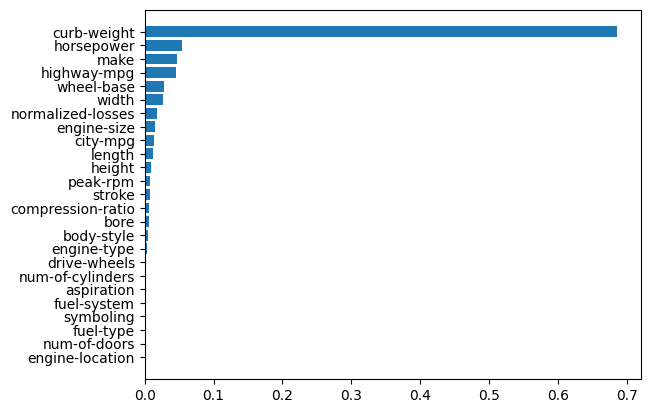

In [10]:
feature_importances = tree_classifier.feature_importances_
indices = np.argsort(feature_importances)
plt.yticks(range(len(indices)), np.array(cleaned_auto_data.drop(["price"], axis=1).columns)[indices])
plt.barh(range(len(indices)), feature_importances[indices])
plt.show()

/tmp/ipykernel_9018/4202594809.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = cleaned_auto_data.corr()


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,compression-ratio,city-mpg,highway-mpg,price
symboling,1.000000,0.559326,-0.171063,0.126148,0.037990,0.660954,-0.570382,-0.076027,NaN,-0.489338,...,-0.498447,-0.176028,-0.081461,-0.025379,-0.009799,0.130440,-0.124006,-0.010282,0.048163,-0.075012
normalized-losses,0.559326,1.000000,-0.267316,0.075168,0.090031,0.441778,-0.379165,0.351681,NaN,-0.092452,...,-0.430914,0.166967,-0.160251,0.137443,0.285627,0.294657,-0.106342,-0.263835,-0.222672,0.306892
make,-0.171063,-0.267316,1.000000,-0.171708,0.117604,-0.191460,0.126873,0.071916,NaN,0.255848,...,0.287180,0.232843,0.015257,0.060002,0.114401,0.211010,0.181173,-0.076220,-0.098935,0.042002
fuel-type,0.126148,0.075168,-0.171708,1.000000,-0.357622,0.179445,-0.153072,-0.124625,NaN,-0.299689,...,-0.241799,-0.201818,0.128412,0.001603,-0.075623,0.095830,-0.984456,-0.288555,-0.235840,-0.129249
aspiration,0.037990,0.090031,0.117604,-0.357622,1.000000,-0.008177,0.036450,0.107778,NaN,0.243344,...,0.027095,0.389264,-0.110796,0.000483,0.244631,0.310077,0.241143,-0.253460,-0.301017,0.344212
num-of-doors,0.660954,0.441778,-0.191460,0.179445,-0.008177,1.000000,-0.672548,0.096119,NaN,-0.450136,...,-0.500947,-0.243486,-0.036071,0.092992,-0.033298,0.020076,-0.172750,0.087038,0.092368,-0.144572
body-style,-0.570382,-0.379165,0.126873,-0.153072,0.036450,-0.672548,1.000000,-0.117593,NaN,0.444895,...,0.588662,0.227087,0.081306,-0.055314,-0.005543,-0.055698,0.143884,-0.063396,-0.100408,0.098788
drive-wheels,-0.076027,0.351681,0.071916,-0.124625,0.107778,0.096119,-0.117593,1.000000,NaN,0.465819,...,-0.003093,0.534206,-0.306445,0.296419,0.542962,0.409417,0.111448,-0.357284,-0.357466,0.571821
engine-location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wheel-base,-0.489338,-0.092452,0.255848,-0.299689,0.243344,-0.450136,0.444895,0.465819,NaN,1.000000,...,0.624055,0.760608,-0.208805,0.005109,0.528277,0.381778,0.249193,-0.479584,-0.522649,0.635553


<AxesSubplot: >

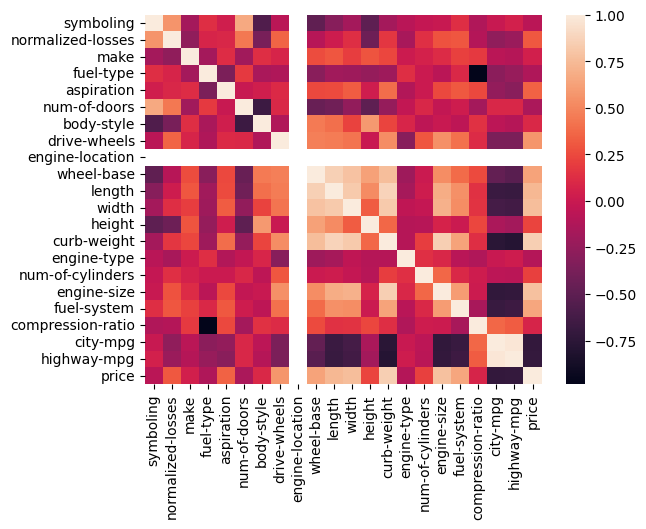

In [11]:
correlation = cleaned_auto_data.corr()
display(correlation)
seaborn.heatmap(correlation)